In [1]:
import netCDF4 as nc
import xarray as xr
import geopandas as gpd
import matplotlib.pyplot as plt
import boto3
import sys
import os
import pandas as pd
import numpy as np

In [2]:
sys.path.append(os.path.expanduser('../../'))
from scripts.utils.write_metadata import (
    make_metadata_files, 
    append_metadata
)

from scripts.utils.file_helpers import to_zarr

In [6]:
#@append_metadata
def crop_condition_moisture(input_nc_file, output_file_name, variable_name=''):
    '''
    Opens a netcdf file for either soil moisture anamoly or evaporative stress index data and reprojects/clips them to California boundaries
    EPSG: 4269. The final output is a reprojected zarr file.

    Note:
    This function assumes users have configured the AWS CLI such that their access key / secret key pair are stored in ~/.aws/credentials.
    See https://docs.aws.amazon.com/cli/latest/userguide/getting-started-install.html for guidance
    
    Parameters
    ----------
    input_nc_file: string
        Name of origional .nc file

    output_file_name: string
        Final output name, as a zar file

    variable_name: string
        Name of the variable associated with the data:
            Soil moisture: 'ssma'
            Evaporative stress index: 'esi'
    '''

    s3_client = boto3.client('s3')  
    bucket_name = 'ca-climate-index'  
    pull_directory = f'1_pull_data/natural_systems/agricultural_productivity_conservation/usda_nasa/{input_nc_file}'


    s3_client.download_file(bucket_name, pull_directory, input_nc_file)

    data = xr.open_dataset(input_nc_file)

    # write the data CRS in CF compliant format
    data = data.rio.write_crs('EPSG:4326') # from documentation
    # set the CRS attribute
    data = data.rio.set_crs('EPSG:4326')

    # establish working range for parameters outlined in the xarray
    lat_min = data['latitude'].min()
    lat_max = data['latitude'].max()
    lon_min = data['longitude'].min()
    lon_max = data['longitude'].max()

    filtered_data = data[variable_name]

    lat_range = lat_max - lat_min
    lon_range = lon_max - lon_min

    # visualize the .nc for the first date within the data
    filtered_data.isel(time=23).plot.imshow(vmin=-4., vmax=4., cmap='seismic', aspect=lon_range/lat_range, size=5)
    # Add a title
    plt.title('.nc file before reproject & CA subset')
    # Display the plot
    plt.show()
    
    # load the census tracts spatial data for California
    census_shp_dir = "s3://ca-climate-index/0_map_data/2021_tiger_census_tract/2021_ca_tract/"
    ca_boundaries = gpd.read_file(census_shp_dir)
    # check the current coordinate system of the census tracts data
    print("Original CRS of Census Tracts Data:")
    print(ca_boundaries.crs)
    print('')

    # check the current coordinate system of the netcdf data
    print("Original CRS of Soil Data:")
    print(filtered_data.spatial_ref.attrs['crs_wkt'])
    print('')

    print('Reprojecting .nc data to census boundaries...')
    # reproject soil data to the same coordinate system as census tract
    filtered_data_repoj = filtered_data.rio.reproject(
        ca_boundaries.crs, nodata=np.nan)
    filtered_data_repoj = filtered_data_repoj.rename(
        {"x" : "lon", "y" : "lat"})
    print("New CRS of Soil Data:")
    print(filtered_data_repoj.spatial_ref.attrs['crs_wkt'])
    print('')

    # clip the reprojected data to California specific census parameter
    filtered_data_repoj = filtered_data_repoj.rio.clip(
        geometries=ca_boundaries.geometry, 
        drop=True,
        all_touched=True,  # keep more data rather than less (for now)
     )
    visualize_ca_evap_stress = filtered_data_repoj.isel(time=23)
    fig, ax = plt.subplots()
    visualize_ca_evap_stress.plot(ax=ax)

    # plot the shapefile on top of the xarray plot
    ca_boundaries.plot(ax=ax, facecolor='none', edgecolor='black', linewidth=0.5)
    plt.title('.nc file after reproject & CA subset')
    # show the plot
    plt.show()
    
    print('Converting reprojected and clipped data to zarr file and uploading to AWS...')
    to_zarr(filtered_data_repoj, '2b_reproject', 'natural_systems', 'agricultural_productivity_conservation', 'usda_nasa', output_file_name)
    print(f'Success, file {output_file_name}.zarr uploaded to AWS!')   

    # Close the NetCDF file
    data.close()

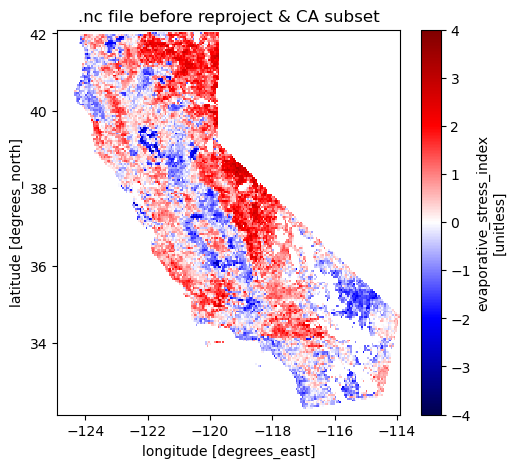

Original CRS of Census Tracts Data:
EPSG:4269

Original CRS of Soil Data:
GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]

Reprojecting .nc data to census boundaries...
New CRS of Soil Data:
GEOGCS["NAD83",DATUM["North_American_Datum_1983",SPHEROID["GRS 1980",6378137,298.257222101]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4269"]]



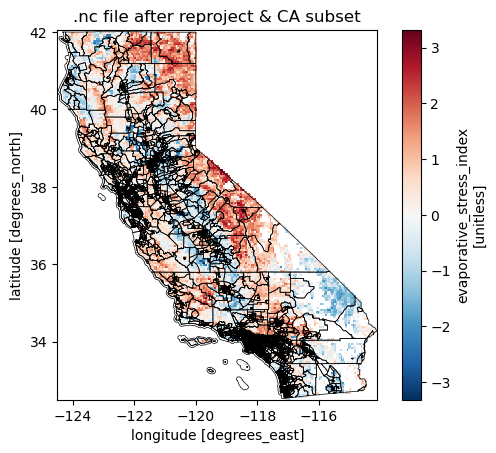

Converting reprojected and clipped data to zarr file and uploading to AWS...
Success, file evaporative_stress_ca_reproject.zarr uploaded to AWS!


In [7]:
crop_condition_moisture('evaporative_stress_index_12week_2015-2022.nc', 'evaporative_stress_ca_reproject', 'esi')

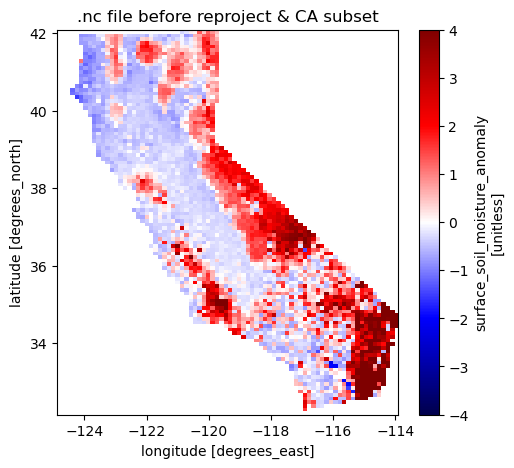

Original CRS of Census Tracts Data:
EPSG:4269

Original CRS of Soil Data:
GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]

Reprojecting .nc data to census boundaries...
New CRS of Soil Data:
GEOGCS["NAD83",DATUM["North_American_Datum_1983",SPHEROID["GRS 1980",6378137,298.257222101]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4269"]]



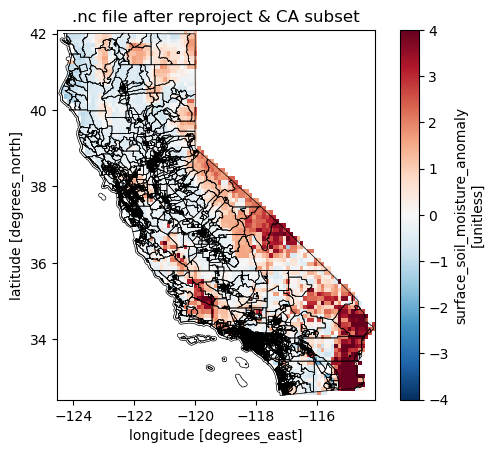

Converting reprojected and clipped data to zarr file and uploading to AWS...
Success, file soil_moisture_anom_ca_reproject.zarr uploaded to AWS!


In [8]:
crop_condition_moisture('sfc_soil_moisture_anomaly_2015-2022.nc', 'soil_moisture_anom_ca_reproject', 'ssma')